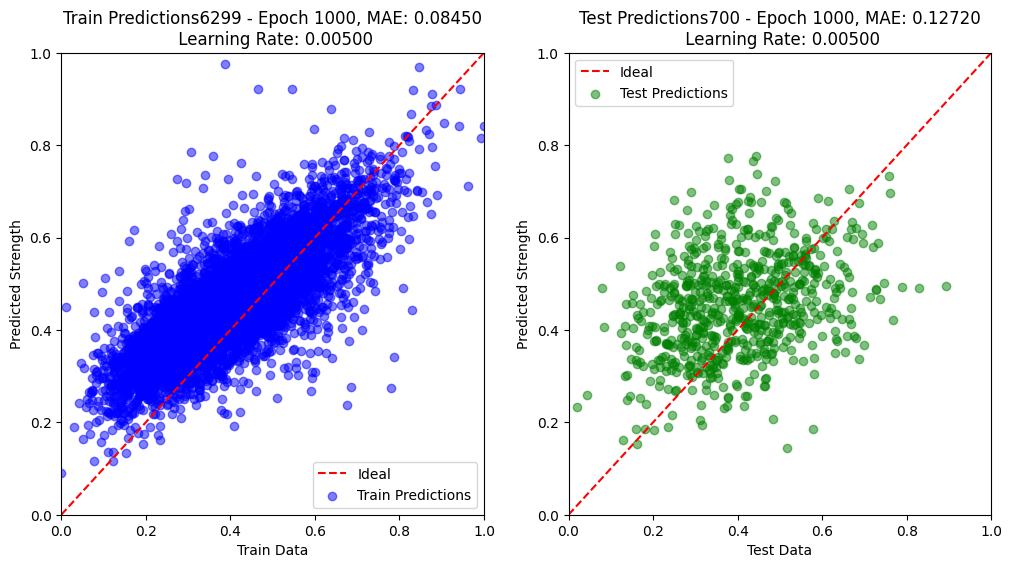

Epoch 1000: Loss = 0.0707156435


In [1]:
import numpy as np
import json
import os
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dense, Dropout, Concatenate, Flatten, Reshape,Conv2DTranspose,BatchNormalization,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from CallBacks import PrintLossCallback, EarlyStoppingByTrainMAE, LiveScatterCNN
import tensorflow as tf
from tensorflow.keras.initializers import HeNormal, GlorotUniform

Iteration=1000
lr=0.005
train_size = 0.9
limit=0.03
l2value=0.01
reduceRate=0.9
modelPath="CNN-2-2.keras"
act="swish"
batch=25
initializer=GlorotUniform()
drop=0.2
# Load node data (25 nodes, 3 features: x, y, z)
with open("nodexy.txt", "r") as file:
    NodeOriginal = json.load(file)
NodeOriginal = np.array(NodeOriginal)  # Convert to NumPy array
# Load element data (features for each sample)
with open("thickness.txt", "r") as file:
    element_features = json.load(file)
element_features = np.array(element_features)  # Convert to NumPy array
# Load target values
energy = np.loadtxt("energy_absorbed.txt")
energy = np.array(energy).reshape(-1, 1)  # Ensure correct shape
minValue=np.argmin(energy)
mask=np.arange((len(energy))) !=minValue
NodeOriginal=NodeOriginal[mask,:,:]
element_features=element_features[mask,:]
energy=energy[mask]
# Extract x, y coordinates
NodeOriginal_x = NodeOriginal[:, :, 0]  # Extract all x-coordinates
NodeOriginal_y = NodeOriginal[:, :, 1]  # Extract all y-coordinates
# Identify and remove edge nodes (x or y = 0 or 30)
_, EdgeNodes = np.where((NodeOriginal_x == 0) | (NodeOriginal_x == 30) | (NodeOriginal_y == 0) | (NodeOriginal_y == 30))
EdgeNodes = np.unique(EdgeNodes)  # Get unique node indices to remove
# Create a mask and filter out edge nodes
mask = np.ones(len(NodeOriginal_x), dtype=bool)
mask[EdgeNodes] = False
filtered_nodes = NodeOriginal[:, :, :]
grid_data_list = []
for sample in filtered_nodes:
    node_positions = sample[:, :2]  # Extract (x, y)
    sorted_indices = np.lexsort((node_positions[:, 0], -node_positions[:, 1]))  # Sort by y (desc), then x (asc)
    sorted_nodes = sample[sorted_indices]  # Reorder nodes spatially
    grid_data = sorted_nodes.reshape(5, 5, 3)  # Convert into 5x5 grid
    grid_data_list.append(grid_data)
node_grid_data = np.array(grid_data_list)

# Normalize data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
scaler_z = MinMaxScaler()
element_scaler = MinMaxScaler()
energy_scaler = MinMaxScaler()
node_grid_data[:, :, :, 0] = scaler_x.fit_transform(node_grid_data[:, :, :, 0].reshape(-1, 1)).reshape(node_grid_data.shape[:3])
node_grid_data[:, :, :, 1] = scaler_y.fit_transform(node_grid_data[:, :, :, 1].reshape(-1, 1)).reshape(node_grid_data.shape[:3])
node_grid_data[:, :, :, 2] = scaler_z.fit_transform(node_grid_data[:, :, :, 2].reshape(-1, 1)).reshape(node_grid_data.shape[:3])
node_grid_data=node_grid_data[:, : , : , 0:2]
element_features = element_scaler.fit_transform(element_features)
energy = energy_scaler.fit_transform(energy)
print(element_features[:2])
print(node_grid_data[:2])

# Convert element connections into a node-centric representation
element_node_map = np.zeros((node_grid_data.shape[0], 5, 5, 4))  # Extra 3 channels for element features
def extract_element_connections(inp_file):
    element_connections = []
    inside_element_section = False  # Flag to track when inside *Element section

    with open(inp_file, 'r') as file:
         for line in file:
            line = line.strip()  # Remove leading/trailing spaces
                
            # Detect start of element section
            if line.startswith("*Element"):
                inside_element_section = True
                continue  # Move to next line
                
                # Detect end of element section (if another keyword appears)
            if inside_element_section and line.startswith("*"):
                break  # Stop reading elements
                
                # Process element connectivity lines
            if inside_element_section and line:
                parts = line.split(",")  # Split by commas
                nodes = tuple(map(int, parts[1:]))  # Convert remaining parts to integers
                element_connections.append(nodes)  # Store the node pair
    return element_connections

    # Example usage:
inp_file_path = "ExplcitBeam.inp"
element_connections = extract_element_connections(inp_file_path)

for i, (sample_nodes, sample_elements) in enumerate(zip(NodeOriginal, element_features)):
    # Extract node positions
    node_positions = sample_nodes[:, :2]
    
    # Sort nodes spatially
    sorted_indices = np.lexsort((node_positions[:, 0], -node_positions[:, 1]))
    sorted_nodes = sample_nodes[sorted_indices]
    
    # Create a mapping from node index to its spatial location
    node_id_to_grid = {idx: (j // 5, j % 5) for j, idx in enumerate(sorted_indices)}

    # Initialize element feature accumulators
    node_element_counts = np.zeros((5, 5))
    node_thickness_sum = np.zeros((5, 5))
    node_thickness_max = np.zeros((5, 5)) - np.inf
    node_thickness_min = np.zeros((5, 5)) + np.inf



    # Process element data
    for elem_idx, (node1, node2) in enumerate(element_connections):  # Assuming element_connections contains pairs
        if node1 in node_id_to_grid and node2 in node_id_to_grid:
            (x1, y1), (x2, y2) = node_id_to_grid[node1], node_id_to_grid[node2]
            thickness = sample_elements[elem_idx]

            # Update both nodes in the grid
            for (x, y) in [(x1, y1), (x2, y2)]:
                node_element_counts[x, y] += 1
                node_thickness_sum[x, y] += thickness
                node_thickness_max[x, y] = max(node_thickness_max[x, y], thickness)
                node_thickness_min[x, y] = min(node_thickness_min[x, y], thickness)

    # Normalize element thickness per node
    avg_thickness = np.divide(node_thickness_sum, node_element_counts, where=node_element_counts > 0, out=np.zeros_like(node_thickness_sum))

    # Fill missing values
    node_thickness_max[node_element_counts == 0] = 0
    node_thickness_min[node_element_counts == 0] = 0

    # Store computed features
    element_node_map[i, :, :, 0] = node_element_counts
    element_node_map[i, :, :, 1] = avg_thickness
    element_node_map[i, :, :, 2] = node_thickness_max
    element_node_map[i, :, :, 3] = node_thickness_min

# Normalize element-related features
scaler_element = MinMaxScaler()
for c in range(1, 4):
    element_node_map[:, :, :, c] = scaler_element.fit_transform(element_node_map[:, :, :, c].reshape(-1, 1)).reshape(element_node_map.shape[:3])

# Combine node data with element features
final_cnn_input = np.concatenate([node_grid_data, element_node_map], axis=-1)  # Shape (samples, 5,5,6)
print(node_grid_data.shape)


# Split data into training and testing sets
X_train_nodes, X_test_nodes, y_train, y_test = train_test_split(final_cnn_input, energy, test_size=1 - train_size, random_state=42)
print(f"y_train shape: {y_train.shape}") 
print(f"X_train_nodes shape: {X_train_nodes.shape}")

# Define CNN model for node features
node_input = Input(shape=(5,5,6), name="Node_Input")
node_branch = BatchNormalization()(node_input)
node_branch = Conv2D(filters=5, kernel_size=(3,3), padding="same",kernel_initializer=initializer)(node_input)
node_branch = BatchNormalization()(node_branch)  # Apply BN first
node_branch = Activation(act)(node_branch)  # Apply activation after BN
node_branch = Conv2D(filters=10, kernel_size=(3,3), padding="same",kernel_initializer=initializer)(node_branch)
node_branch = BatchNormalization()(node_branch)
node_branch = Activation(act)(node_branch)
node_branch = Conv2D(filters=15, kernel_size=(3,3), padding="same",kernel_initializer=initializer)(node_branch)
node_branch = BatchNormalization()(node_branch)
node_branch = Activation(act)(node_branch)
node_branch = GlobalAveragePooling2D()(node_branch)
 # Reduce to 1D

# Concatenate CNN and ANN features
latentSpace=Dense(50,activation=act,kernel_regularizer=l2(l2value),kernel_initializer=initializer)(node_branch)
latentSpace=Dense(30,activation=act,kernel_initializer=initializer)(latentSpace)
latentSpace=Dropout(drop)(latentSpace)
latentSpace=Dense(10,kernel_initializer=initializer,name="Latent")(latentSpace)
latentSpace=Dropout(drop)(latentSpace)
merged = Dense(4,kernel_initializer=initializer)(latentSpace)
merged = Dense(2,kernel_initializer=initializer)(merged)
encode = Dense(1, activation="linear", name="Encode")(merged)

decoded = Dense(40, activation=act,kernel_regularizer=l2(l2value),kernel_initializer=initializer)(latentSpace)
decoded = Dense(75, activation=act,kernel_regularizer=l2(l2value),kernel_initializer=initializer)(decoded)
decoded = Dense(25*6, activation=act,kernel_regularizer=l2(l2value),kernel_initializer=initializer)(decoded)
decoded = Reshape((5,5,6))(decoded)
decoded = Conv2DTranspose(12, kernel_size=(3,3), activation=act, padding="same",kernel_initializer=initializer)(decoded)
decode = Conv2DTranspose(6, kernel_size=(3,3), activation=act, padding="same",kernel_initializer=initializer,name="Decode")(decoded)
#decode = Reshape((5,5,7), name="Decode")(decoded)

# Create model
if os.path.exists(modelPath):
    print("Loading model")
    model=load_model(modelPath)
else:
    print("Creating model")
    model = Model(inputs=[node_input], outputs=[encode,decode])
def log_cosh_loss(y_true, y_pred):
    return tf.reduce_mean(tf.math.log(tf.cosh(y_pred - y_true)))
model.compile(optimizer=Adam(learning_rate=lr), 
              loss={"Encode": "huber", "Decode":"huber"},
              #loss_weights={"Encode": 0.5, "Decode": 0.5},
              metrics={"Encode": ["mae", "mse"], "Decode": ["mae", "mse"]})

# Define callbacks for early stopping and learning rate reduction
checkpoint = ModelCheckpoint(modelPath, monitor="Encode_mae", save_best_only=True, mode="min", verbose=0)
reduce_lr = ReduceLROnPlateau(monitor="Encode_mae", factor=reduceRate, patience=200, min_lr=1e-6, verbose=0)
X_train_nodes = np.array(X_train_nodes, dtype=np.float32)
LossMonitor = PrintLossCallback("Encode_mae",interval=10)
early_stopping = EarlyStoppingByTrainMAE("Encode_mae",threshold=limit)
plot=LiveScatterCNN(X_train_nodes,X_test_nodes, y_train, y_test, interval=10)

print(f"Model output shapes: {[o.shape for o in model.outputs]}")
print(f"y_train shape: {y_train.shape}") 
print(f"X_train_nodes shape: {X_train_nodes.shape}")
print("Target Min:", np.min(y_train), "Target Max:", np.max(y_train))
# Train model
history = model.fit(
    X_train_nodes,
    [y_train, X_train_nodes],
    epochs=Iteration,
    batch_size=batch,
    validation_split=0.1,
    callbacks=[checkpoint,reduce_lr,plot,LossMonitor],
    verbose=0
)
